# Machine Learning Final Project - Early Sepsis Prediction

# Problem Statement:
Sepsis is the body's extreme response to an infection. It is also defined as a life-threatening organ dysfunction caused by a dysregulated host response to infection.

The numbers are alarming and are estimated to be 11.3 million cases with 2.9 fatalities in India itself in 2017.

We have to predict sepsis diagnosis 6 hours prior to manifestation.

# Bonus Problem Statement

We have to prdict sepsis diagnosis 12 hours prior to manifestation.

# Expected Outcome
We have to explore domain knowledge to effectively engineer features from the provided dataset (41 features) to predict the target variable Sepsis Label by applying the machine learning concepts we learnt in class. (Algorithms - Supervised / Unsupervised Learning)

### References refered for developing the approach for solving the Sepsis Prediction 

[1] https://www.physionet.org/content/challenge-2019/1.0.0/ \
[2] https://towardsdatascience.com/early-detection-of-sepsis-using-physiological-data-78d5f31fab9d \
[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6429642/ \
[4] https://towardsdatascience.com/metrics-for-imbalanced-classification-41c71549bbb5 \
[5] https://www.hindawi.com/journals/cin/2021/6522633/ \
[6] https://www.sciencedirect.com/science/article/abs/pii/S016926071831602X \
[7] https://academic.oup.com/jamia/article/29/3/559/6460282 \
[8] https://www.mdpi.com/2079-9292/9/7/1133 \
[9] https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87 \
[10] https://medium.com/ibm-data-ai/using-machine-learning-to-predict-outcomes-for-sepsis-patients-cde5625ce9cb 

And research paper revelant to Sepsis prediction to under the features and problem statement properly.

### This Notebook contains the approach towards the prediciton of Sepsis in t-6 hours while we have made another Notebook where we attempted to calculated the Sepsis prediction for t-12 hours, where t is the time hour when sepsis is detected.


## Importing all libraries

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as clf1
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.linear_model import Perceptron
from sklearn.metrics import precision_score, classification_report,average_precision_score, accuracy_score, balanced_accuracy_score, precision_recall_curve, f1_score, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
import eli5
from eli5.sklearn import PermutationImportance
print("All Libraries are imported")


All Libraries are imported


# Approach Followed

*  Created Fucntion to read the psv file as well appended with the patient ID & hour to the data frame generated.
*  Read all the psv files csv dataset. <br>

In [ ]:
def read_dataset_psv(filepath,datatable):
    count,rows = 0,0
#     rows = 0
    for filename in os.listdir(filepath):
        if filename.endswith(".psv"): 
            with open(filepath + filename) as openfile:
                patient = filename.split("p")[1]
                patient = patient.split(".")[0]

                file = pd.read_csv(openfile,sep = "|")
                file['Patient_ID'] = patient
                
                file = file.reset_index()
                file = file.rename(columns={"index": "Hour"})
                
                datatable = datatable.append(file)
                
                rows += file.size
                count += 1
        # Print progress after 10k files
        if count % 10000 == 0:
            print("Progress || Files: {} || Number of items: {}".format(count,rows))
    print("Done ||| Files: {} || Number of items: {}".format(count,rows))
    return(datatable)

Created File Path to convert all Hospital A data into training data set & testing data set while Hospital B dataset is used for the Validation purpose.<br>
Stored both the dataframe to CSV for the further use.

In [ ]:
# fpath1 = "/training_setA/training/"
# fpath2 = "/training_setB/training_setB/"

# df = pd.DataFrame()
# df_v = pd.DataFrame()
# data = read_dataset_psv("/kaggle/input/prediction-of-sepsis/training_setA/training/",df)
# data_v = read_dataset_psv("/kaggle/input/prediction-of-sepsis/training_setB/training_setB/",df_v)

In [ ]:
# data.to_csv('/kaggle/working/train.csv',index=False)

In [ ]:
# data_v.to_csv('/kaggle/working/test.csv',index=False)

Reading Data through Pandas

In [1]:
df = pd.read_csv('/kaggle/input/mimic3-sepsis-data/train.csv')
print(len(df))
df.head()

790215


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0,1
1,1,1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0,1
2,2,2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0,1
3,3,3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0,1
4,4,4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0,1


In [2]:
df_v = pd.read_csv('/kaggle/input/mimic3-sepsis-data/test.csv')
print(len(df_v))
df_v.head()

761995


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,73,1,1.0,0.0,-214.64,1,0,100001
1,1,1,93.0,92.5,NaN,110.0,76.0,56.0,22.0,NaN,...,NaN,NaN,73,1,1.0,0.0,-214.64,2,0,100001
2,2,2,91.0,96.0,NaN,108.0,84.5,72.0,23.5,NaN,...,NaN,NaN,73,1,1.0,0.0,-214.64,3,0,100001
3,3,3,93.0,98.0,NaN,123.0,87.0,61.0,21.0,NaN,...,NaN,NaN,73,1,1.0,0.0,-214.64,4,0,100001
4,4,4,93.0,95.0,NaN,110.0,81.0,70.0,20.0,NaN,...,NaN,NaN,73,1,1.0,0.0,-214.64,5,0,100001


Stastics Analysis through available Library.

In [4]:
df.shape

(790215, 44)

In [5]:
df_v.shape

(761995, 44)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,790215.0,25.332445,27.954160,0.00,9.00,20.00,33.00,335.00
Hour,790215.0,25.332445,27.954160,0.00,9.00,20.00,33.00,335.00
HR,729026.0,84.985264,16.940431,20.00,73.00,84.00,96.00,280.00
O2Sat,695136.0,97.265688,2.908794,20.00,96.00,98.00,99.50,100.00
Temp,266901.0,37.026737,0.780317,20.90,36.56,37.06,37.55,42.22
SBP,670014.0,120.962359,21.520567,22.00,105.00,118.50,134.00,281.00
MAP,709357.0,78.767345,15.044038,20.00,68.00,77.00,87.33,300.00
DBP,409918.0,59.985809,12.572771,20.00,51.00,58.50,67.00,298.00
Resp,712957.0,18.773460,5.395750,1.00,15.00,18.00,22.00,69.00
EtCO2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790215 entries, 0 to 790214
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        790215 non-null  int64  
 1   Hour              790215 non-null  int64  
 2   HR                729026 non-null  float64
 3   O2Sat             695136 non-null  float64
 4   Temp              266901 non-null  float64
 5   SBP               670014 non-null  float64
 6   MAP               709357 non-null  float64
 7   DBP               409918 non-null  float64
 8   Resp              712957 non-null  float64
 9   EtCO2             0 non-null       float64
 10  BaseExcess        82381 non-null   float64
 11  HCO3              63617 non-null   float64
 12  FiO2              112155 non-null  float64
 13  pH                90615 non-null   float64
 14  PaCO2             69288 non-null   float64
 15  SaO2              39160 non-null   float64
 16  AST               11

In [8]:
df.drop(['Unnamed: 0'], axis=1, inplace = True)

* Checked the count of null values in each feature, and ploted features by % null values in descending order.<br>
* Checked the % of population having sepsis vs not having sepsis. INSIGHT: Here, we realized that the problem has a class imbalance of 8.8% unique patients with sepsis (1790 count) vs 91.2% unique healthy patients.<br>
* It Showcase the data Imbalance existence in the dataset.

<AxesSubplot:>

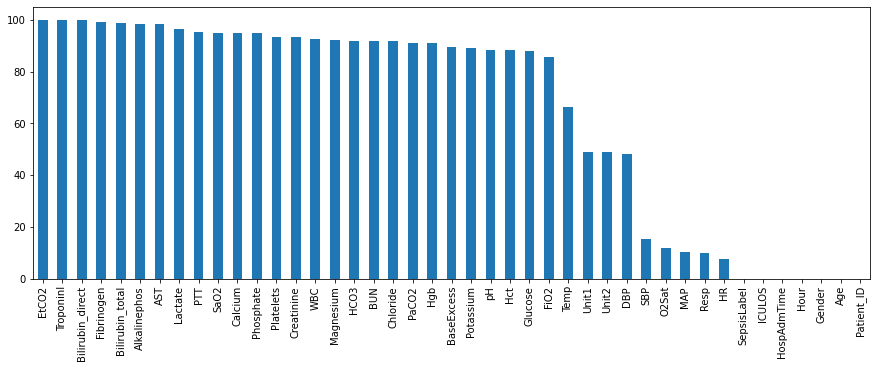

In [9]:
#Missing value in the training dataset 
hist_df = round(100*(df.isnull().sum()/len(df.index)),2).sort_values(ascending=False)
histogram_df = hist_df.plot.bar(figsize=(15,5))
histogram_df

<AxesSubplot:>

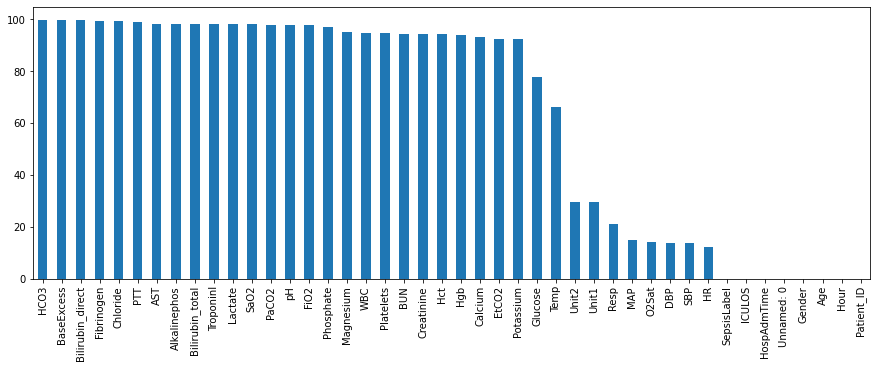

In [10]:
#Missing value in the validation dataset 
hist_df_v = round(100*(df_v.isnull().sum()/len(df_v.index)),2).sort_values(ascending=False)
histogram_df_v = hist_df_v.plot.bar(figsize=(15,5))
histogram_df_v

In [11]:
df_patients = len(df['Patient_ID'][df['SepsisLabel']==1].unique())
dataset_total_patients = len(df['Patient_ID'].unique())
sepsis_percentage = df_patients/dataset_total_patients
print("Sepsis Patients in the dataset : %.4f" % sepsis_percentage)

Sepsis Patients in the dataset : 0.0880


In [12]:
df_patients_v = len(df_v['Patient_ID'][df_v['SepsisLabel']==1].unique())
dataset_total_patients_v = len(df_v['Patient_ID'].unique())
sepsis_percentage_v = df_patients_v/dataset_total_patients_v
print("Sepsis Patients in the dataset : %.4f" % sepsis_percentage_v)

Sepsis Patients in the dataset : 0.0571


#### Exploratory Analysis of Patients admitted with the Sepsis to explore the understanding the feature importance for Sepsis Patients.

In [14]:
#list of patients who is suffering from sepsis before admission to ICU
adm_with_sepsis=df['Patient_ID'][(df['SepsisLabel']==1) & (df['Hour']==0)]
print("Total patients admission with sepsis:",len(adm_with_sepsis))

Total patients admission with sepsis: 203


In [15]:
# construct dataframe of patients who have sepsis before admission to ICU
adm_with_sepsis_data=df[df.Patient_ID.isin(adm_with_sepsis)]

In [16]:
# a = dataset.describe().T - adm_with_sepsis_data.describe().T
# a
adm_with_sepsis_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,1768.0,3.885181,2.552193,0.00,2.00,4.000,6.000,9.00
HR,1555.0,92.042765,18.710873,41.50,78.00,91.500,105.000,160.00
O2Sat,1485.0,97.397643,3.059654,68.00,96.00,98.000,100.000,100.00
Temp,582.0,36.942715,1.167719,32.50,36.28,36.900,37.700,40.44
SBP,1310.0,114.556489,23.190079,57.00,98.00,111.250,128.000,227.00
MAP,1529.0,75.367567,15.691380,28.50,65.00,74.000,84.000,186.00
DBP,716.0,58.110684,12.180334,23.00,50.00,57.000,65.000,125.00
Resp,1532.0,19.797161,5.998682,5.00,15.50,18.500,23.000,67.00
EtCO2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BaseExcess,329.0,-1.449848,5.723007,-17.00,-5.00,-1.000,2.000,15.00


In [17]:
adm_with_sepsis_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768 entries, 2212 to 786652
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Hour              1768 non-null   int64  
 1   HR                1555 non-null   float64
 2   O2Sat             1485 non-null   float64
 3   Temp              582 non-null    float64
 4   SBP               1310 non-null   float64
 5   MAP               1529 non-null   float64
 6   DBP               716 non-null    float64
 7   Resp              1532 non-null   float64
 8   EtCO2             0 non-null      float64
 9   BaseExcess        329 non-null    float64
 10  HCO3              218 non-null    float64
 11  FiO2              390 non-null    float64
 12  pH                336 non-null    float64
 13  PaCO2             267 non-null    float64
 14  SaO2              111 non-null    float64
 15  AST               78 non-null     float64
 16  BUN               222 non-null    flo

In [18]:
adm_with_sepsis_data.head(100)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
2212,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.20,1,1.0,0.0,-140.06,1,1,56
2213,1,86.0,100.0,36.39,118.0,73.00,57.0,17.0,NaN,NaN,...,NaN,NaN,68.20,1,1.0,0.0,-140.06,2,1,56
2214,2,86.0,97.0,36.89,116.0,75.00,59.0,16.0,NaN,NaN,...,NaN,NaN,68.20,1,1.0,0.0,-140.06,3,1,56
2215,3,84.0,96.5,36.56,141.0,87.00,66.0,15.5,NaN,NaN,...,NaN,NaN,68.20,1,1.0,0.0,-140.06,4,1,56
2216,4,85.0,97.0,NaN,147.0,90.00,66.0,14.0,NaN,NaN,...,NaN,NaN,68.20,1,1.0,0.0,-140.06,5,1,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49305,2,84.0,95.0,NaN,76.0,40.67,NaN,17.0,NaN,NaN,...,NaN,NaN,79.51,0,1.0,0.0,-227.20,3,1,1272
49306,3,81.0,98.0,NaN,NaN,NaN,NaN,14.0,NaN,NaN,...,NaN,NaN,79.51,0,1.0,0.0,-227.20,4,1,1272
49307,4,88.0,95.0,NaN,91.0,49.67,NaN,20.0,NaN,NaN,...,NaN,NaN,79.51,0,1.0,0.0,-227.20,5,1,1272
49308,5,86.0,92.0,NaN,87.0,47.00,NaN,19.0,NaN,NaN,...,NaN,NaN,79.51,0,1.0,0.0,-227.20,6,1,1272


Exploratory Analysis of Missing Values in the dataset & various visualization techniques to interpret the correlation among features.
* We plotted a correlation heatmap. INSIGHT: We saw that features Unit 1 and Unit 2 are complementary to each other.
* It is observed that row items for class imbalance in the dataset. INSIGHT: There is a class imbalance of 97.8% healthy rows vs 2.16% sepsis rows.<br>
* Plotted the distibutions for all features to see distributions, concentrations and skewness.<br>
* Plotted a dendogram to visualize which features are closely related and created a hierarchy of similarities.<br>
* Plotted box plots for each feature to understand the standard deviations and presence of outliers.<br>

<AxesSubplot:>

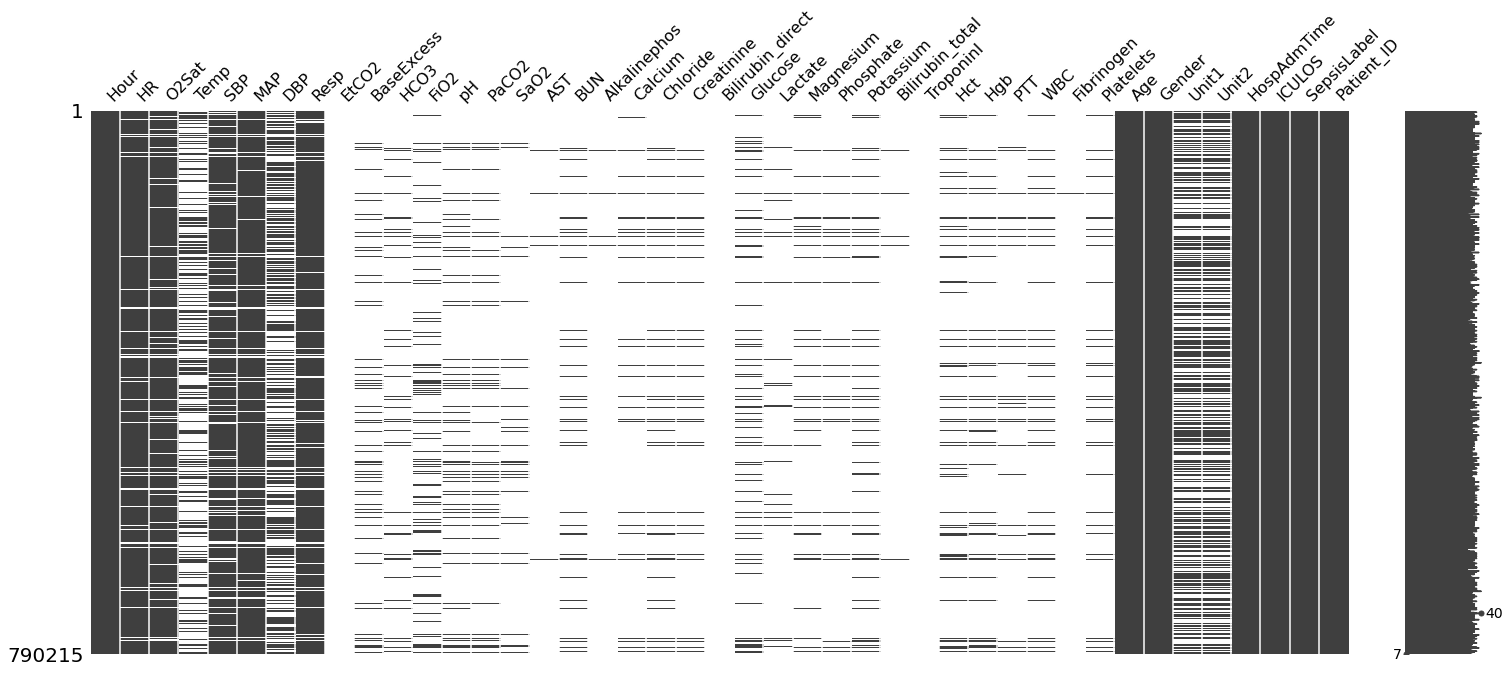

In [19]:
msno.matrix(df)

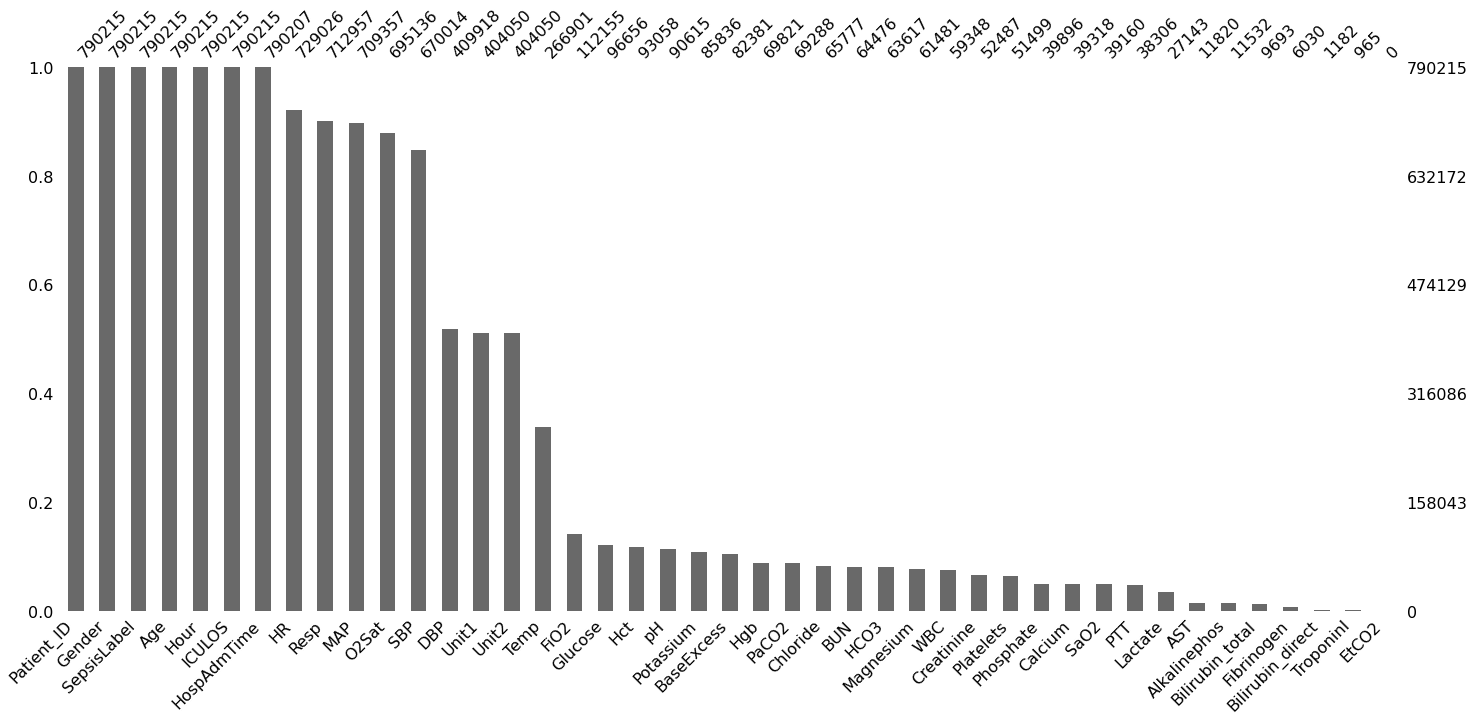

In [20]:
msno.bar(df, sort="descending");

In [21]:
print("Count of Sepsis Label = 0:",len(df[df['SepsisLabel'] == 0]))
print("Count of Sepsis Label = 1:",len(df[df['SepsisLabel'] == 1]))

Count of Sepsis Label = 0: 773079
Count of Sepsis Label = 1: 17136


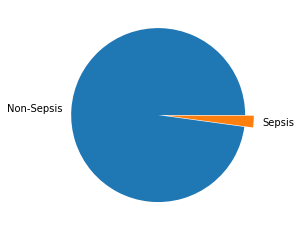

In [22]:
y = np.array([len(df[df['SepsisLabel'] == 0]), len(df[df['SepsisLabel'] == 1])])
mylabels = ["Non-Sepsis", "Sepsis"]
myexplode = [0, 0.1]
plt.pie(y, labels = mylabels, explode = myexplode)
plt.show()

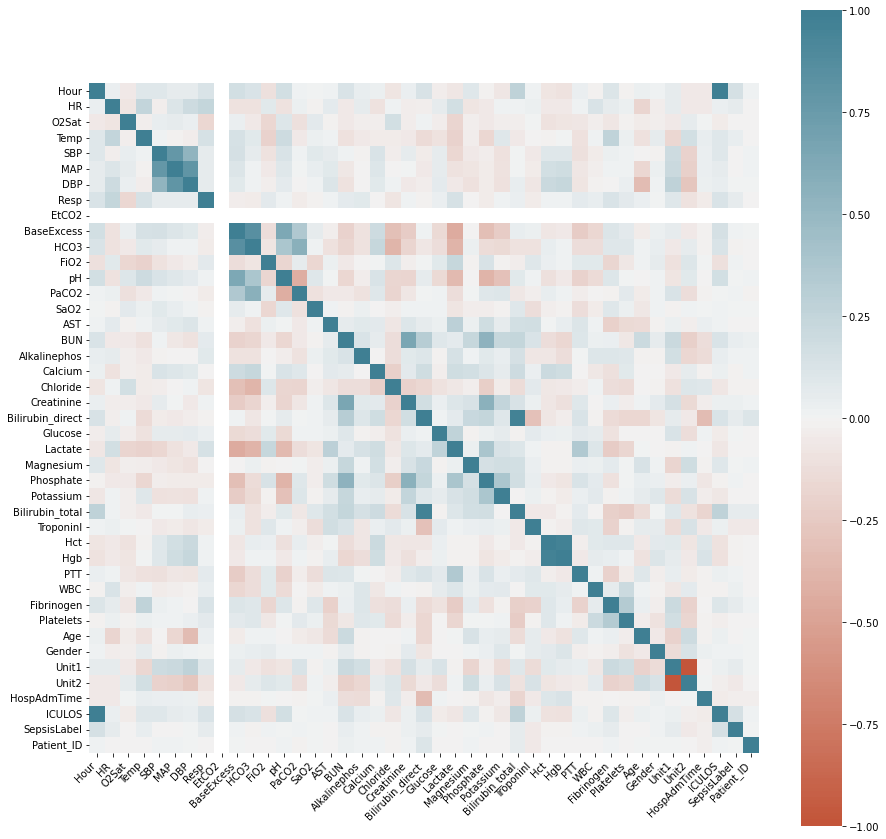

In [23]:
fig = plt.figure(figsize=(15,15))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Plotting the distribution of all the columns

We can observe the mean value and range of values for all the columns. 

Few observations we can make:
1. Most columns have a small standard deviation.
2. There are no values in EtCO2
3. There is large variance in the ages of patients
4. There is a large imbalance in the sepsis labels.

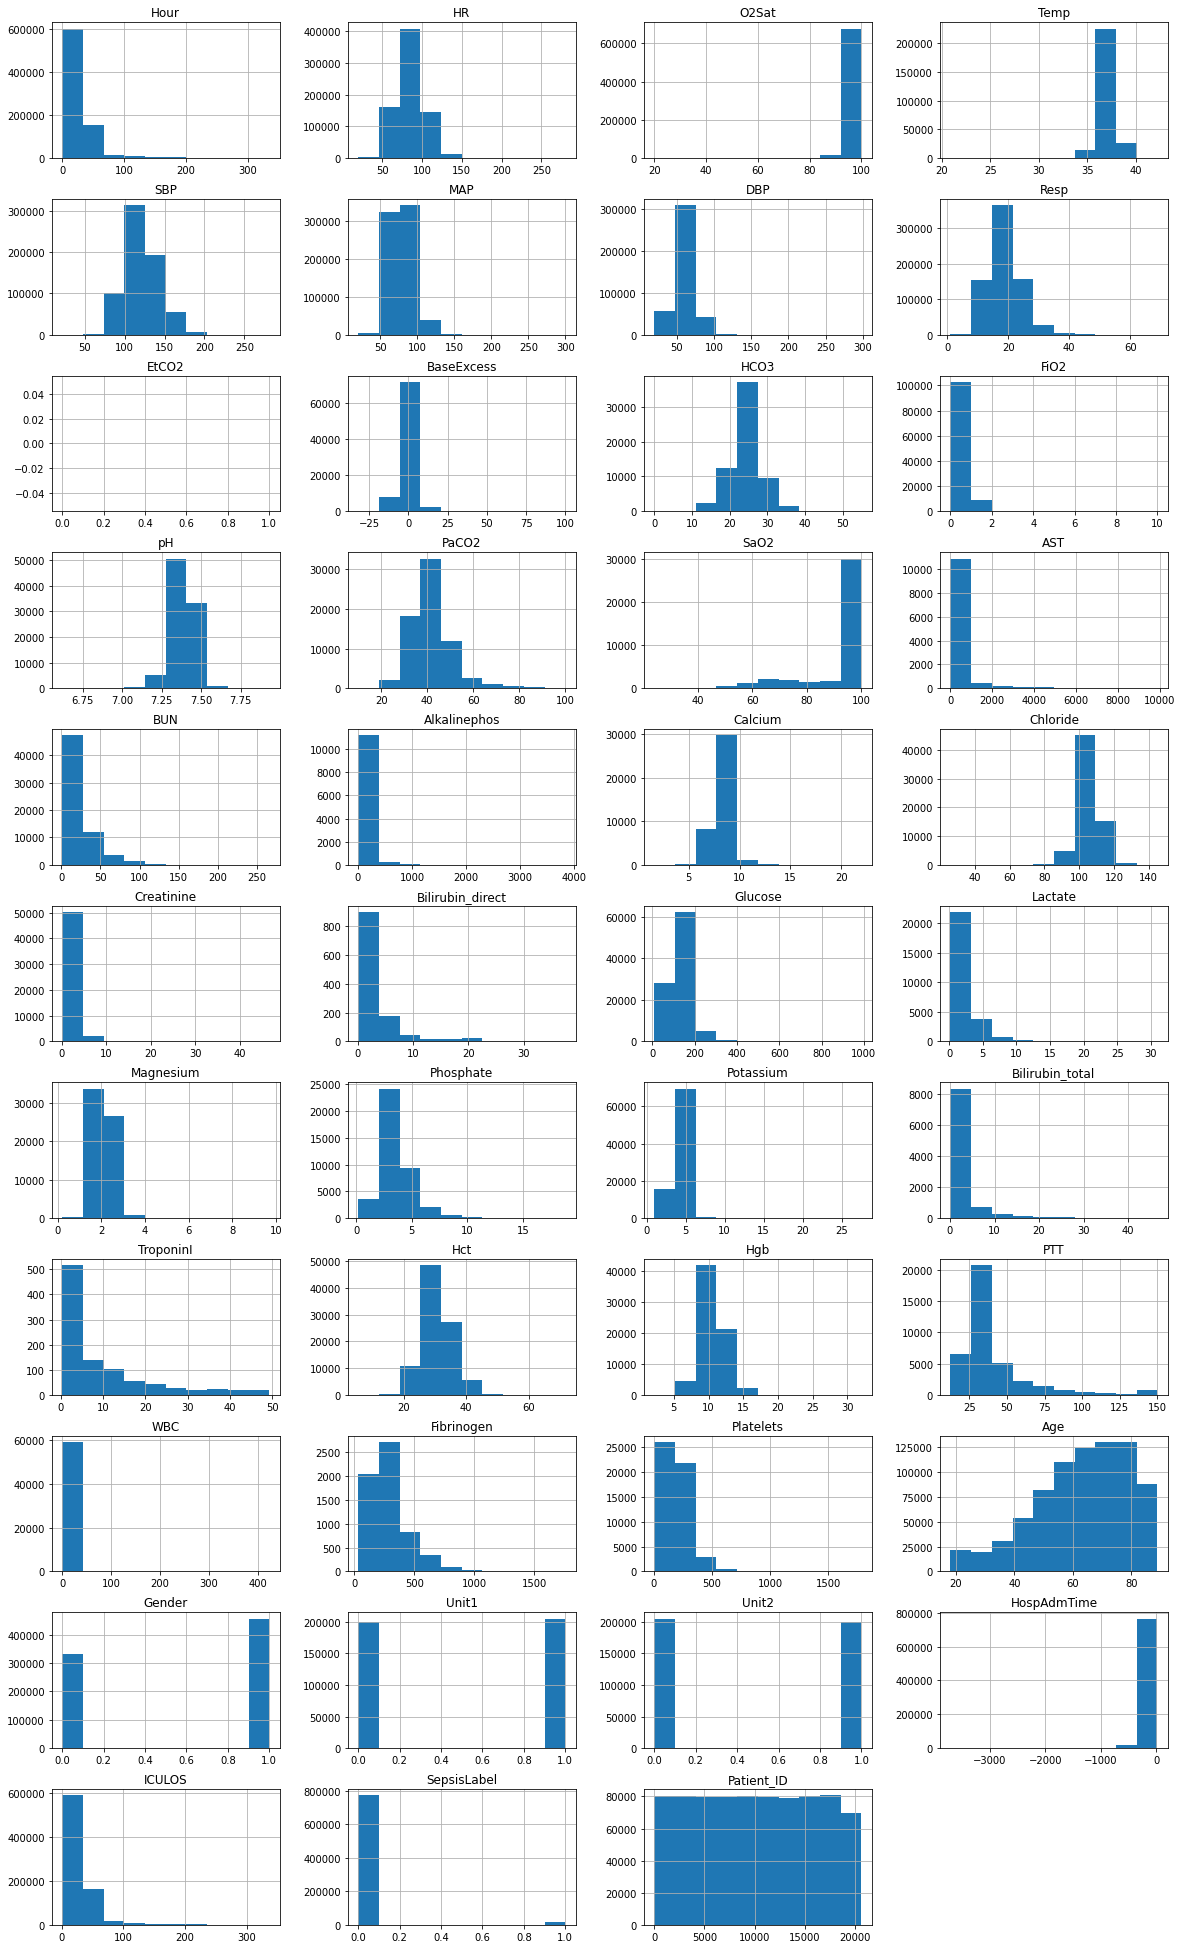

In [24]:
df.hist(layout=(11,4), figsize=(20,35))
plt.show()

# Dendrogram

Similar pairs of features are selected to make a hierarchical structure.

<AxesSubplot:>

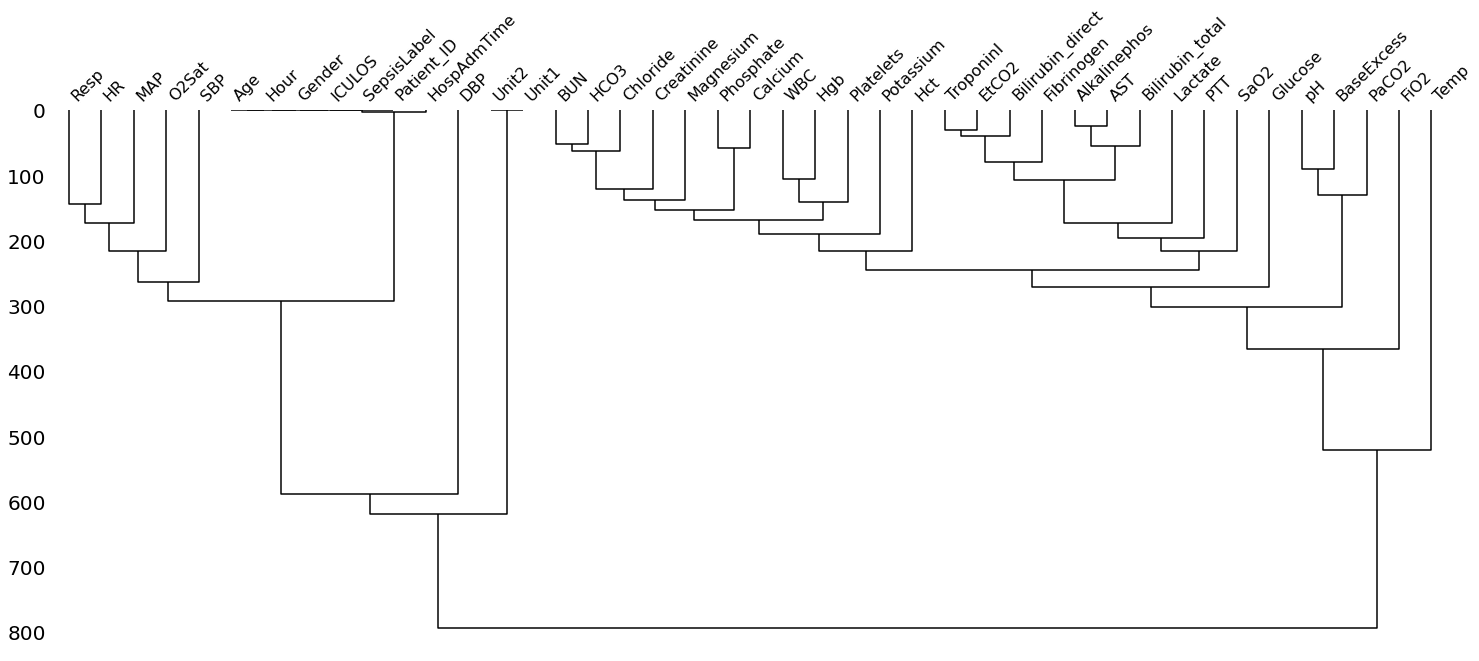

In [25]:
msno.dendrogram(df)

# Box Plots of all columns

We can see the outliers by plotting Box Plots for each columns

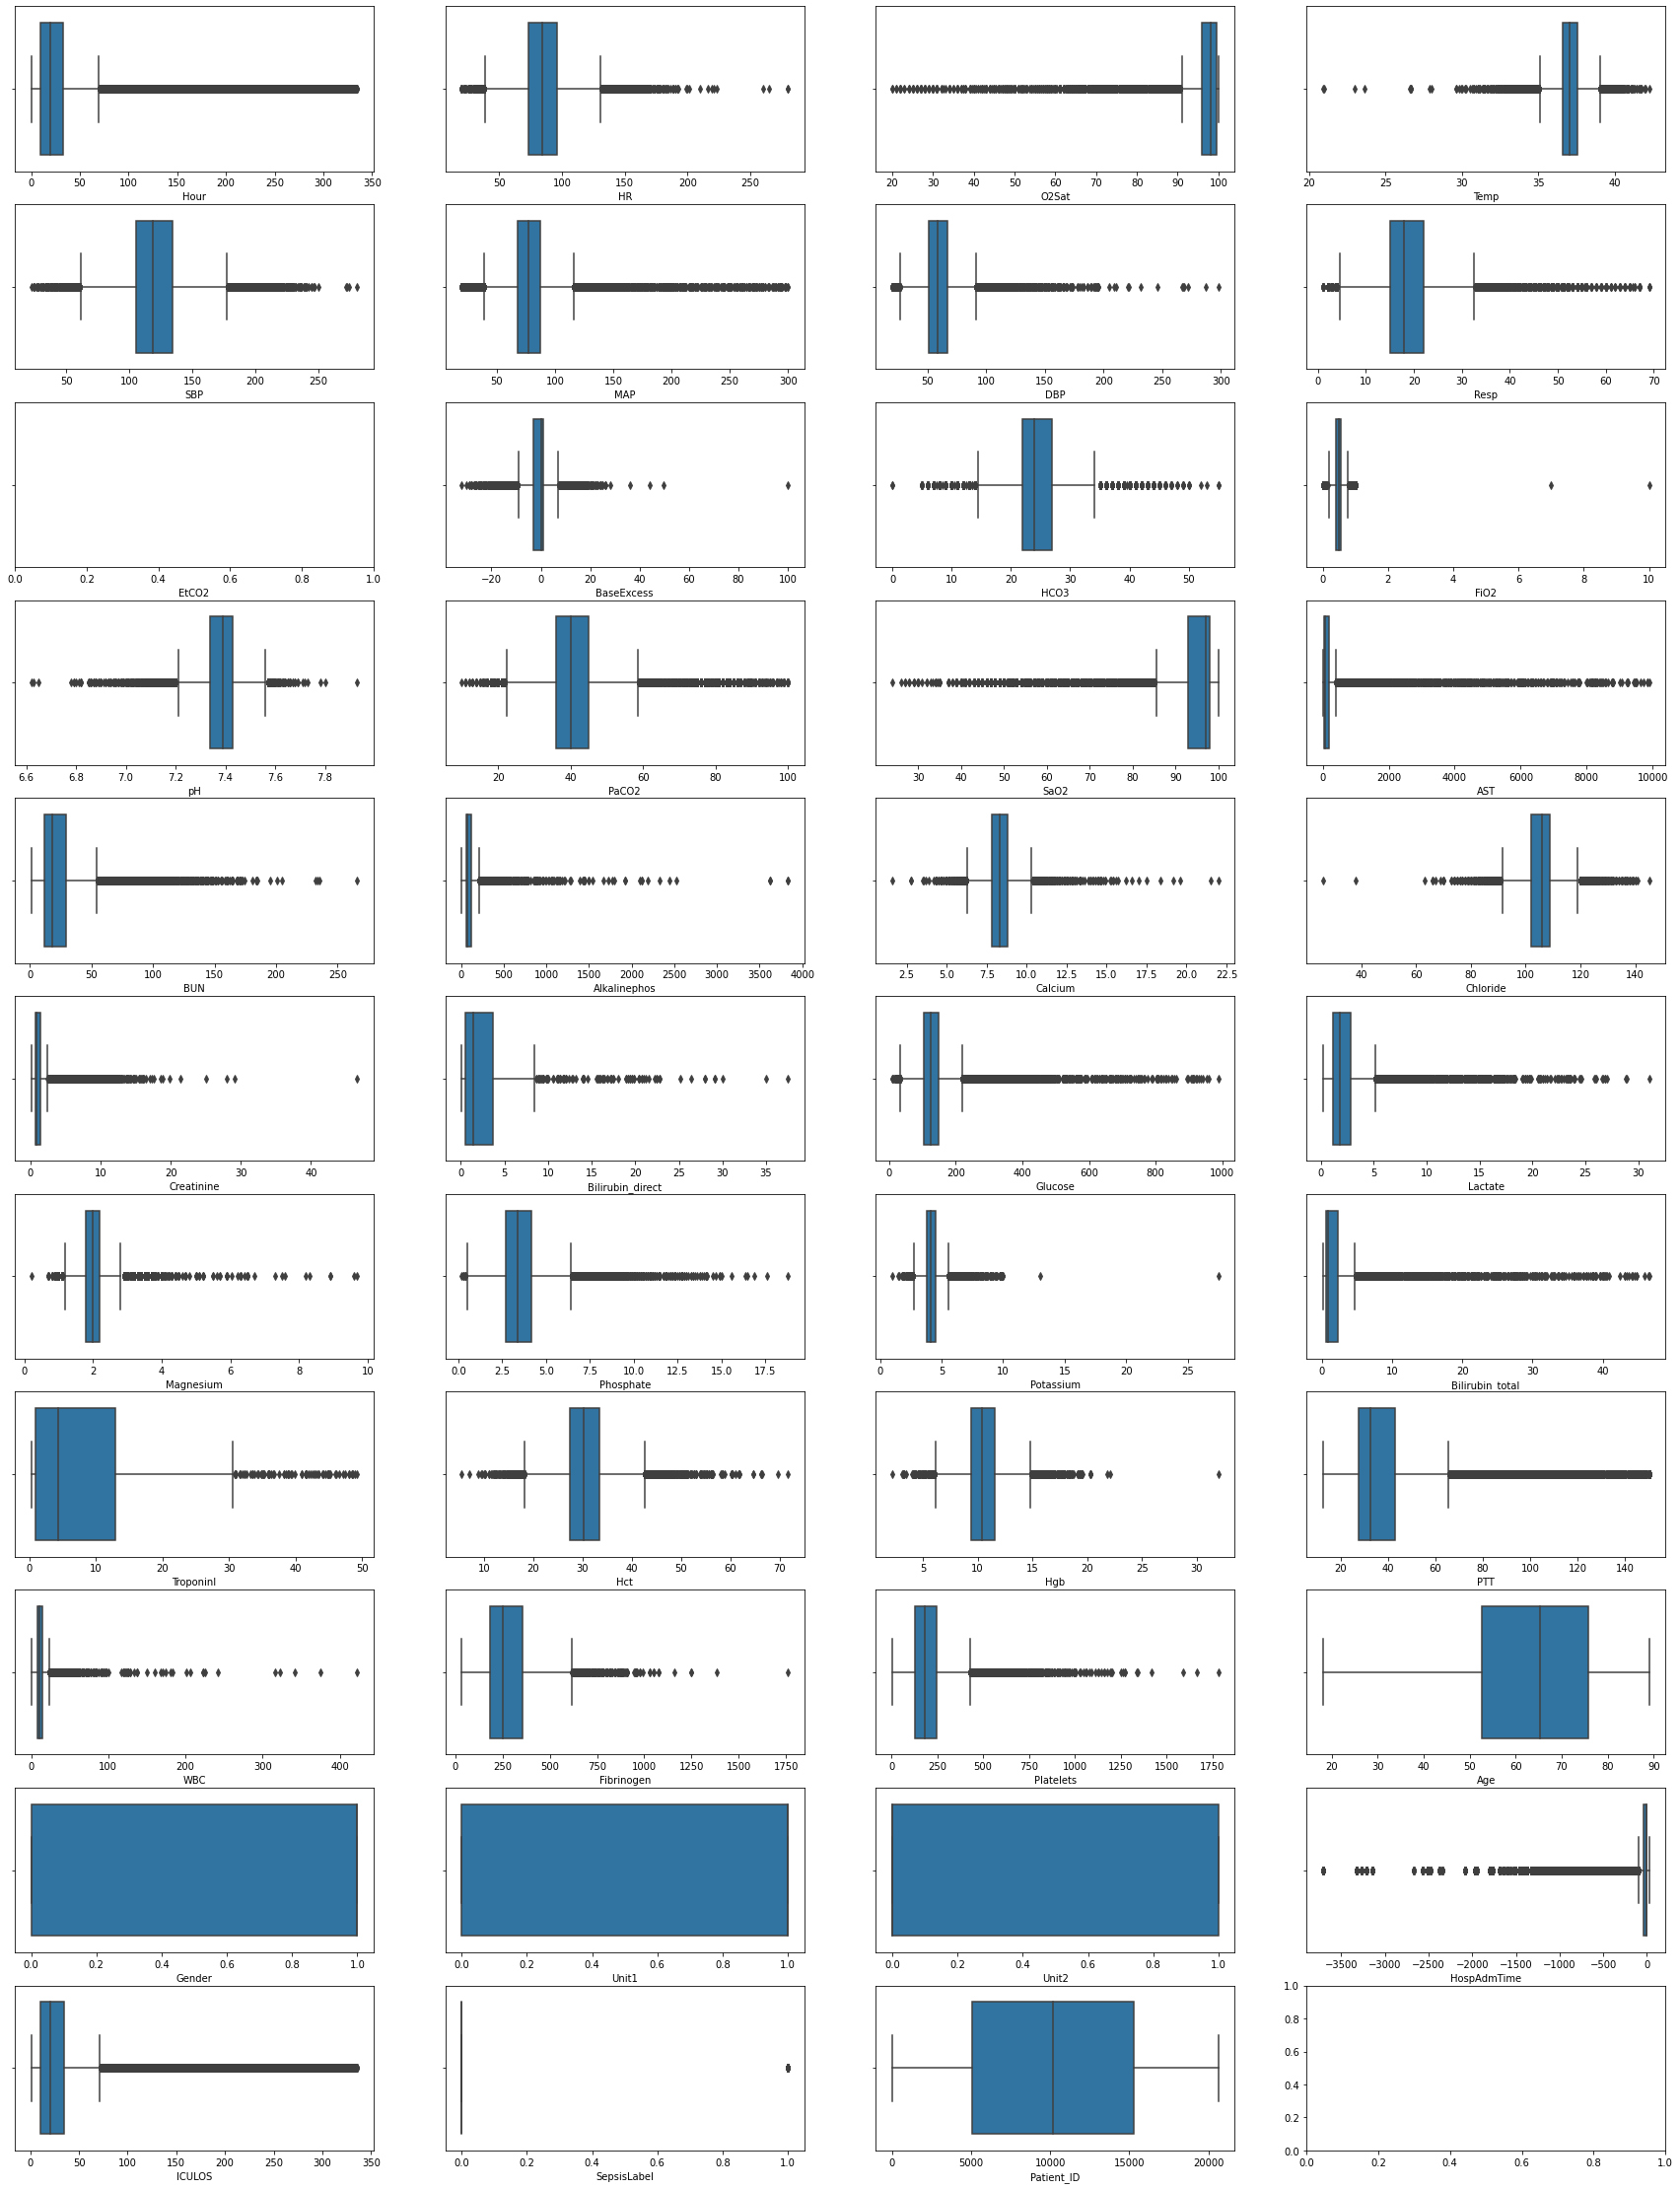

In [26]:
f, axes = plt.subplots(11, 4, figsize=(30,40), sharex=False)
axes = axes.flatten()
for idx, column in enumerate(df.columns[:]):
    sns.boxplot(x = df[column], ax = axes[idx])

# Pre-Processing / Data Cleaning<br>

* We have dropped all features where null values are greater than 92%. (eg EtCO2, TroponinI, Fibrinogen, Calcium etc.)<br>
* Reason behind dropping all features greater than 92% because as per consultations with Doctor told it is not right to calculate the  features from very few values there could be possibly bias towards the mean or median.

In [27]:
df_1 = pd.DataFrame(columns = ['Column Name', '% Null Values'])
for column in df.columns[1:]:
    df_1.loc[len(df_1.index)] = [column , 100*df[column].isnull().sum()/len(df)]
print(df_1.sort_values(by=['% Null Values'], ascending=False))

         Column Name  % Null Values
7              EtCO2     100.000000
27         TroponinI      99.877881
20  Bilirubin_direct      99.850420
32        Fibrinogen      99.236917
26   Bilirubin_total      98.773372
16      Alkalinephos      98.540650
14               AST      98.504205
22           Lactate      96.565112
30               PTT      95.152459
13              SaO2      95.044387
17           Calcium      95.024392
24         Phosphate      94.951247
33         Platelets      93.482913
19        Creatinine      93.357884
31               WBC      92.489639
23         Magnesium      92.219712
9               HCO3      91.949406
15               BUN      91.840702
18          Chloride      91.676063
12             PaCO2      91.231753
29               Hgb      91.164303
8         BaseExcess      89.574863
25         Potassium      89.137640
11                pH      88.532868
28               Hct      88.223711
21           Glucose      87.768392
10              FiO2      85

In [28]:
raw_data = df
miss_data = raw_data.isnull().sum()
miss_per = (miss_data/raw_data.shape[0])*100
final_columns = list(miss_per[miss_per < 92].index)
sepsis_data = raw_data[final_columns]

In [29]:
sepsis_data.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Glucose', 'Potassium', 'Hct', 'Hgb', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [30]:
sepsis_data.shape 

(790215, 27)

## Imputation: 
This is probably the most important part of the pre-processing.<br>
        i. Single Imputer (Mean / Median / Mode): This is the simplest method, but is not suitable for the domain of healthcare. We came to this conclusion post literature review and talk with Health expert.<br>
        ii. Forward-Backward Imputation: Null values are first imputed by the first value to the top. The values on the top are left out as there is no value to take reference from. Once this is completed, the remaining null values are imputed by the first value to the bottom.<br>
        iii. Backward-Forward Imputation: Null values are first imputed by the first value to the bottom. The values on the bottom are left out as there is no value to take reference from. Once this is completed, the remaining null values are imputed by the first value to the top.<br>
        iv. MICE (Multivariate Imputation by Chained Equation): It is the most used algorithm for imputation.<br>
        v. Linear Interpolation followed by backward fill: It is the estimation of an unknown value within 2 known values, followed by backfill to fill any null values at the top. Based on all experiments, we concluded that linear interpolation is the most suitable method to impute our features as it gives similar values following previous trends.<br>
        
 We have tried all above mentioned Imputation methods but we got better results with Linear Interpolation and direction of limit is both.
 
 Implemented imputation on both training & validation dataset.

In [31]:
SelCol = ['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Glucose', 'Potassium', 'Hct', 'Hgb', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID']

In [32]:
df = sepsis_data

In [34]:
interpolate_df = df.groupby(['Patient_ID']).apply(lambda x: x[SelCol].interpolate(method='linear', limit_direction='both'))
interpolate_df_v = df_v.groupby(['Patient_ID']).apply(lambda x: x[SelCol].interpolate(method='linear', limit_direction='both'))

In [35]:
interpolate_df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,Hct,Hgb,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,97.0,95.0,36.11,98.0,75.330,NaN,19.0,24.000000,45.0,...,37.2,12.5,83.14,0,NaN,NaN,-0.03,1,0,1
1,1,97.0,95.0,36.11,98.0,75.330,NaN,19.0,24.000000,45.0,...,37.2,12.5,83.14,0,NaN,NaN,-0.03,2,0,1
2,2,89.0,99.0,36.11,122.0,86.000,NaN,22.0,24.000000,45.0,...,37.2,12.5,83.14,0,NaN,NaN,-0.03,3,0,1
3,3,90.0,95.0,36.11,122.0,88.665,NaN,30.0,24.000000,45.0,...,37.2,12.5,83.14,0,NaN,NaN,-0.03,4,0,1
4,4,103.0,88.5,36.11,122.0,91.330,NaN,24.5,23.857143,45.0,...,37.2,12.5,83.14,0,NaN,NaN,-0.03,5,0,1


In [36]:
df = interpolate_df
df_v = interpolate_df_v

# Feature Transformation / Engineering
The new feature designed for heart rate takes into account both Age and Heart Rate in a patient. It has three categories - normal, abnormal, missing

* The 'normal' HR for a child (Age < 10) is in the range of 70 to 110 beats per minute.
* The 'normal' HR for a adult and senior (Age 10+) is in the range of 60 to 100
* Any other values recorded is marked as 'abnormal'.
* The value 'missing' is filled in place of null/nan values
 
The blood oxygen level measured with an oximeter is called your oxygen saturation level. This is a percentage of how much oxygen your blood is carrying compared to the maximum it is capable of carrying.

The new feature designed for pulse oximetry takes into three catogories

* 'Normal' is found to be between 95% - 100% in healthy children and adults alike
* 'Abnormal' is for anything otherwise
* 'Missing' is a null or nan case is observed

The new feature designed for temperature takes into three categories:

* Body temperature for any healthy person (child, adult and senior alike) is 'normal' when found between 36 Deg C to 38 Dec C.
* Anything above or below this range is labeled as 'abnormal'
* 'Missing' is a null or nan case is observed

We will be combining two forms of Blood Pressure here - Systolic blood pressure (SBP) and Diastolic Blood Pressure(DBP) in the dataset.

SBP - When your heart beats, it squeezes and pushes blood through your arteries to the rest of your body. This force creates pressure on those blood vessels, and that's your systolic blood pressure

DBP - The diastolic reading, or the bottom number, is the pressure in the arteries when the heart rests between beats. This is the time when the heart fills with blood and gets oxygen.

The new feature will compare the two BP and according to the below table categorize into four categories 
* low
* normal
* elevated
* high
* missing

The new feature designed will have 3 categories - normal, abnormal and missing. The normal respiratory rate for different age groups are as shown below:

For healthy adults (Age > 18) is between 12 and 20 breaths per minute.

Normal respiratory rates for children in breaths per minute are as follows:

* birth to 1 year: 30 to 60
* 1 to 3 years: 24 to 40
* 3 to 6 years: 22 to 34
* 6 to 12 years: 18 to 30
* 12 to 18 years: 12 to 16
Any other range for respiratory rates are labeled as 'abnormal' and the missing values are labeled as 'missing


Instead of Label Encoder we have coded directly through function in the feature transformations:<br>
        i. Age as 0,1,2 for child, adult, senior<br>
        ii. Heart rate as 0,1,2 for normal, abnormal, missing<br>
        iii. O2Sat as 0,1,2 for normal, abnormal, missing<br>
        iv. Body Temperature as 0,1,2 for normal, abnormal, missing<br>
        v. Blood Pressure as 0,1,2,3 for normal, elevated, high, missing<br>
        vi. Respiration Rate as 0,1,2 for normal, abnormal, missing<br>
        vii. Mean Arterial Pressure as 0,1,2 for normal, abnormal, missing<br>
        viii. Fraction of inspired oxygen as 0,1,2 for normal, abnormal, missing<br>
        ix. pH code as 0,1,2 for normal, abnormal, missing<br>
        x. Bicarbonate as 0,1,2 for normal, abnormal, missing<br>
        xi. Blood Urea Nitrogen as 0,1,2 for normal, abnormal, missing<br>

In [37]:
def age_code(data):
    data.loc[data['Age'] >=60, 'age_code'] = 0
    data.loc[data['Age'] <10, 'age_code'] = 1
    data.loc[(data['Age'] >=10) & (data['Age'] <60),'age_code'] = 2
    return data

def hr_code(data): 
    data.loc[(data['HR'] >= 70) & (data['HR'] < 110 ) & (data['Age'] < 10), 'hr_code'] = 0
    data.loc[(data['HR'] > 60) & (data['HR'] < 100) & data['Age'] >= 10, 'hr_code'] = 0
    data.loc[((data['HR'] < 70) | (data['Age'] >= 110)) & (data['Age']<10), 'hr_code'] = 1
    data.loc[(data['HR'] >= 100) & (data['Age'] >= 10), 'hr_code'] = 1
    data['hr_code'].fillna(2, inplace=True)
    return data

def o2sat_code(data):
    data.loc[(data['O2Sat'] >= 95) & (data['O2Sat'] < 100), 'o2sat_code'] = 0
    data.loc[(data['O2Sat'] < 95) & (data['O2Sat'] >= 0), 'o2sat_code'] = 1
    data['o2sat_code'].fillna(2, inplace=True)
    return data

def temp_code(data):
    data.loc[(data['Temp'] >= 36) & (data['Temp'] < 38),'temp_code'] = 0
    data.loc[(data['Temp'] < 36) | (data['Temp'] >= 38),'temp_code'] = 1
    data['temp_code'].fillna(2, inplace=True)
    return data

def bp_code(data):
    data.loc[(data['SBP'] < 90) & (data['DBP'] < 60), 'bp_code'] = 0
    data.loc[(data['SBP'].between(90,120, inclusive=True)) & (data['DBP'].between(60,80, inclusive=True)), 'bp_code'] = 1
    data.loc[(data['SBP'].between(120,140, inclusive=True)) & (data['DBP'].between(80,90, inclusive=True)),'bp_code'] = 2
    data.loc[(data['SBP'] > 140 ) & (data['DBP'] > 90 ), 'bp_code'] = 3
    data['bp_code'].fillna(4, inplace=True)
    return data

def resp_code(data):
    data.loc[(data['Resp'].between(30, 60)) & (data['Age'] < 1), 'resp_code'] = 0
    data.loc[(data['Resp'].between(24, 40)) & (data['Age'].between(1, 3)), 'resp_code'] = 0
    data.loc[(data['Resp'].between(22, 34)) & (data['Age'].between(3, 6)), 'resp_code'] = 0
    data.loc[(data['Resp'].between(18, 30)) & (data['Age'].between(6, 12)), 'resp_code'] = 0
    data.loc[(data['Resp'].between(12, 16)) & (data['Age'].between(12, 18)), 'resp_code'] = 0
    data.loc[(data['Resp'].between(12, 20)) & (data['Age'] > 18), 'resp_code'] = 0
    
    data.loc[((data['Resp'] < 30) | (data['Resp'] > 60)) & (data['Age'] <1) ,'resp_code'] = 1  
    data.loc[((data['Resp'] < 24) | (data['Resp'] > 40)) & (data['Age'].between(1, 3)) ,'resp_code'] = 1   
    data.loc[((data['Resp'] < 22) | (data['Resp'] > 34)) & (data['Age'].between(3, 6)) ,'resp_code'] = 1
    data.loc[((data['Resp'] < 18) | (data['Resp'] > 30)) & (data['Age'].between(6, 12)) ,'resp_code'] = 1
    data.loc[((data['Resp'] < 12) | (data['Resp'] > 16)) & (data['Age'].between(12, 18)) ,'resp_code'] = 1
    data.loc[((data['Resp'] < 12) | (data['Resp'] > 20)) & (data['Age'] > 18) ,'resp_code'] = 1
    
    data['resp_code'].fillna(2, inplace = True)
                                                            
    return data

def map_code(data):
    data.loc[(data['MAP'] >= 70) & (data['MAP'] < 100),'map_code'] = 0
    data.loc[(data['MAP'] < 70) | (data['MAP'] >= 100),'map_code'] = 1
    data['map_code'].fillna(2, inplace=True)
    return data

def fio2_code(data):
    data.loc[(data['FiO2'] < 0.8 ) ,'fio2_code'] = 0
    data.loc[(data['FiO2'] >= 0.8 ),'fio2_code'] = 1
    data['fio2_code'].fillna(2, inplace=True)
    return data

def ph_code(data):
    data.loc[(data['pH'] >= 7.35) & (data['pH'] < 7.45),'ph_code'] = 0
    data.loc[(data['pH'] < 7.35) | (data['pH'] >= 7.45),'ph_code'] = 1
    data['ph_code'].fillna(2, inplace=True)
    return data

def hco3_code(data):
    data.loc[(data['HCO3'] >= 22) & (data['HCO3'] < 26),'hco3_code'] = 0
    data.loc[(data['HCO3'] < 22) | (data['HCO3'] >= 26),'hco3_code'] = 1
    data['hco3_code'].fillna(2, inplace=True)
    return data

def bun_code(data):
    data.loc[(data['BUN'] >= 10) & (data['BUN'] < 20),'bun_code'] = 0
    data.loc[(data['BUN'] < 10) | (data['BUN'] >= 20),'bun_code'] = 1
    data['bun_code'].fillna(2, inplace=True)
    return data



def masterfunction(data):
    data1 = age_code(data)
    data2 = hr_code(data1)
    data3 = o2sat_code(data2)
    data4 = temp_code(data3)
    data5 = bp_code(data4)
    data6 = resp_code(data5)
    data7 = map_code(data6)
    data8 = fio2_code(data7)
    data9 = ph_code(data8)
    data10 = hco3_code(data9)
    data11 = bun_code(data10)
    return data11

df = masterfunction(df)
df_v = masterfunction(df_v)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


In [38]:
df.head().T

,0,1,2,3,4
Hour,0.00,1.00,2.00,3.000,4.000000
HR,97.00,97.00,89.00,90.000,103.000000
O2Sat,95.00,95.00,99.00,95.000,88.500000
Temp,36.11,36.11,36.11,36.110,36.110000
SBP,98.00,98.00,122.00,122.000,122.000000
MAP,75.33,75.33,86.00,88.665,91.330000
DBP,NaN,NaN,NaN,NaN,NaN
Resp,19.00,19.00,22.00,30.000,24.500000
BaseExcess,24.00,24.00,24.00,24.000,23.857143
HCO3,45.00,45.00,45.00,45.000,45.000000


In [39]:
df.drop(['Unit1','Unit2'],axis=1,inplace=True)
df_v.drop(['Unit1','Unit2'],axis=1,inplace=True)
df.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Glucose', 'Potassium', 'Hct', 'Hgb', 'Age', 'Gender', 'HospAdmTime',
       'ICULOS', 'SepsisLabel', 'Patient_ID', 'age_code', 'hr_code',
       'o2sat_code', 'temp_code', 'bp_code', 'resp_code', 'map_code',
       'fio2_code', 'ph_code', 'hco3_code', 'bun_code'],
      dtype='object')

In [40]:
print('Train columns with null values: \n', df.isnull().sum())
print("-"*10)
print (df.info())
print("-"*10)

print('Test/Validation columns with null values: \n', df_v.isnull().sum())
print("-"*10)
print (df_v.info())
print("-"*10)

df.describe(include = 'all')

Train columns with null values: 
 Hour                0
HR                  9
O2Sat             211
Temp             6746
SBP              9971
MAP                24
DBP            258145
Resp              701
BaseExcess     257035
HCO3            10270
FiO2           286023
pH             236723
PaCO2          259499
BUN              7410
Chloride        10357
Glucose          7433
Potassium        8067
Hct              6156
Hgb              9156
Age                 0
Gender              0
HospAdmTime         8
ICULOS              0
SepsisLabel         0
Patient_ID          0
age_code            0
hr_code             0
o2sat_code          0
temp_code           0
bp_code             0
resp_code           0
map_code            0
fio2_code           0
ph_code             0
hco3_code           0
bun_code            0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 790215 entries, 0 to 790214
Data columns (total 36 columns):
 #   Column       Non-Null Count   Dtyp

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,hr_code,o2sat_code,temp_code,bp_code,resp_code,map_code,fio2_code,ph_code,hco3_code,bun_code
count,790215.000000,790206.000000,790004.000000,783469.000000,780244.000000,790191.000000,532070.000000,789514.000000,533180.000000,779945.000000,...,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000,790215.000000
mean,25.332445,84.927417,97.209745,36.930997,121.019686,78.926498,60.748476,18.768839,0.093226,24.573993,...,1.810745,0.598895,0.160787,3.562854,0.380838,0.367842,0.794767,0.861278,0.582876,0.575769
std,27.954160,17.004225,3.172422,0.717040,21.739801,15.025764,13.352571,5.359366,4.044265,4.150572,...,0.391711,0.841192,0.389882,1.088147,0.487417,0.482281,0.941820,0.847711,0.518773,0.512849
min,0.000000,20.000000,20.000000,20.900000,22.000000,20.000000,20.000000,1.000000,-32.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,73.000000,96.000000,36.483333,105.000000,68.670000,52.000000,15.000000,-2.000000,22.000000,...,2.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,84.000000,98.000000,36.912500,119.000000,77.000000,59.000000,18.000000,0.000000,24.466667,...,2.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,33.000000,96.000000,99.111111,37.390000,135.000000,88.000000,68.000000,22.000000,2.000000,27.000000,...,2.000000,1.000000,0.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000
max,335.000000,280.000000,100.000000,42.220000,281.000000,300.000000,298.000000,69.000000,100.000000,55.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [43]:
df.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Glucose', 'Potassium', 'Hct', 'Hgb', 'Age', 'Gender', 'HospAdmTime',
       'ICULOS', 'SepsisLabel', 'Patient_ID', 'age_code', 'hr_code',
       'o2sat_code', 'temp_code', 'bp_code', 'resp_code', 'map_code',
       'fio2_code', 'ph_code', 'hco3_code', 'bun_code'],
      dtype='object')

In [48]:
df_train_test = df.copy()
df_train_test = df_train_test.drop([ 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Chloride',
       'Glucose', 'Potassium', 'Hct', 'Hgb', 'Age'], axis=1)
df_train_test.fillna(method='bfill',inplace = True)
df_train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790215 entries, 0 to 790214
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Hour         790215 non-null  int64  
 1   Gender       790215 non-null  int64  
 2   HospAdmTime  790215 non-null  float64
 3   ICULOS       790215 non-null  int64  
 4   SepsisLabel  790215 non-null  int64  
 5   Patient_ID   790215 non-null  int64  
 6   age_code     790215 non-null  float64
 7   hr_code      790215 non-null  float64
 8   o2sat_code   790215 non-null  float64
 9   temp_code    790215 non-null  float64
 10  bp_code      790215 non-null  float64
 11  resp_code    790215 non-null  float64
 12  map_code     790215 non-null  float64
 13  fio2_code    790215 non-null  float64
 14  ph_code      790215 non-null  float64
 15  hco3_code    790215 non-null  float64
 16  bun_code     790215 non-null  float64
dtypes: float64(12), int64(5)
memory usage: 108.5 MB


In [49]:
df_train_test.isnull().sum()

Hour           0
Gender         0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
Patient_ID     0
age_code       0
hr_code        0
o2sat_code     0
temp_code      0
bp_code        0
resp_code      0
map_code       0
fio2_code      0
ph_code        0
hco3_code      0
bun_code       0
dtype: int64

## Oversampling of dataset
To oversample a minority class in a classification algorithm, SMOTE (Synthetic Minority Oversampling Technique) is applied. It generates new minority class instances by combining existing minority class instances, rather than just replicating existing instances as some other oversampling algorithms do. SMOTE is used to balance the class distribution in a dataset since many machine learning methods perform better when the classes are balanced. Furthermore, oversampling the minority class can assist to reduce the consequences of an uneven class distribution on classifier performance.

In [50]:
X = df_train_test.drop(["SepsisLabel"],axis=1)
y = df_train_test["SepsisLabel"]
SMOTE = SMOTE()

print('Original dataset shape %s' % Counter(y))

X_res, y_res = SMOTE.fit_resample(X,y)

print('After undersample dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 773079, 1: 17136})
After undersample dataset shape Counter({0: 773079, 1: 773079})


In [51]:
df_train_test.fillna(method='ffill', inplace=True)

feature_df = df_train_test.iloc[:,[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16]]
target_df = df_train_test.iloc[:,[4]]

In [52]:
X_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546158 entries, 0 to 1546157
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Hour         1546158 non-null  int64  
 1   Gender       1546158 non-null  int64  
 2   HospAdmTime  1546158 non-null  float64
 3   ICULOS       1546158 non-null  int64  
 4   Patient_ID   1546158 non-null  int64  
 5   age_code     1546158 non-null  float64
 6   hr_code      1546158 non-null  float64
 7   o2sat_code   1546158 non-null  float64
 8   temp_code    1546158 non-null  float64
 9   bp_code      1546158 non-null  float64
 10  resp_code    1546158 non-null  float64
 11  map_code     1546158 non-null  float64
 12  fio2_code    1546158 non-null  float64
 13  ph_code      1546158 non-null  float64
 14  hco3_code    1546158 non-null  float64
 15  bun_code     1546158 non-null  float64
dtypes: float64(12), int64(4)
memory usage: 188.7 MB


In [53]:
X_res.isnull().sum()

Hour           0
Gender         0
HospAdmTime    0
ICULOS         0
Patient_ID     0
age_code       0
hr_code        0
o2sat_code     0
temp_code      0
bp_code        0
resp_code      0
map_code       0
fio2_code      0
ph_code        0
hco3_code      0
bun_code       0
dtype: int64

#### The train/test split is an important technique in machine learning as it helps to ensure that the model is not overfitting to the training data, and that it is able to generalize to unseen data.

In [54]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,test_size=0.3)

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1082310 entries, 1360455 to 530362
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Hour         1082310 non-null  int64  
 1   Gender       1082310 non-null  int64  
 2   HospAdmTime  1082310 non-null  float64
 3   ICULOS       1082310 non-null  int64  
 4   Patient_ID   1082310 non-null  int64  
 5   age_code     1082310 non-null  float64
 6   hr_code      1082310 non-null  float64
 7   o2sat_code   1082310 non-null  float64
 8   temp_code    1082310 non-null  float64
 9   bp_code      1082310 non-null  float64
 10  resp_code    1082310 non-null  float64
 11  map_code     1082310 non-null  float64
 12  fio2_code    1082310 non-null  float64
 13  ph_code      1082310 non-null  float64
 14  hco3_code    1082310 non-null  float64
 15  bun_code     1082310 non-null  float64
dtypes: float64(12), int64(4)
memory usage: 140.4 MB


In [56]:
X_train.columns

Index(['Hour', 'Gender', 'HospAdmTime', 'ICULOS', 'Patient_ID', 'age_code',
       'hr_code', 'o2sat_code', 'temp_code', 'bp_code', 'resp_code',
       'map_code', 'fio2_code', 'ph_code', 'hco3_code', 'bun_code'],
      dtype='object')

# Machine Learning Algorithm

We have applied following ML Algorithm on the dataset:

* Loggistic Regresion
* Decision Tree
* Random Forest
* Gaussian Naive Bayes
* Balanced Bagging Classifier
* Ada Boost Classifier
* Gradient Boosting Classifier
* Linear SVC
* Linear Discriminant Analysis
* Quadratic Discriminant Analysis
* Perceptron
* XGBoost

We have tried SVC & NN but it was taking too much time to get the train on 15 lacs data points as well as Kernel get died on Collab, Kaggle & own PC so not applying here.

Created pipelines, which are used to streamline the process of training and testing models. They allow you to chain multiple preprocessing and modeling steps together in a single, unified workflow. This can be helpful for a number of reasons:

* Consistency: Pipelines ensure that all data goes through the same processing steps, so you don't have to worry about forgetting to apply a certain preprocessing step to the test set that you applied to the training set.
 
* Simplicity: Pipelines allow you to specify all of the steps in your workflow in a single place, rather than having to write separate code for each step.

* Reusability: You can use pipelines to encapsulate your entire modeling process, making it easy to reuse with new datasets or in different parts of your codebase.

* Automation: You can use pipelines to automate the process of training and evaluating multiple models with different hyperparameters, saving you time and effort.

In pipeline we have applied first of all Min Max Scaler and it is followed by dimensional reduction techniques - PCA & LDA. At the end, we are applying the Machine Learning algorithm.

Created Dictionary in which all algorithms are mentioned and applied for loop to produce the evaluation metrics & ROC curve for each algorithm.

Following Algorithms producing more than 90% of accuracy as well as F1 score on the train dataset:
* Decision Tree
* Random Forest
* Balanced Bagging Classifier
* XGBoost

In [125]:
LogisticRegressionPipeline=Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('logistic_classifier',LogisticRegression(C= 1000, penalty='l2'))])
DecisionTreePipeline=Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('decisiontree_classifier',DecisionTreeClassifier())])
RandomForestPipeline=Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('randomforest_classifier',RandomForestClassifier())])
GNBPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('Gausian_Naive_Bayes_classifier',GaussianNB(priors=None))])
BBCPipeline = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
ABCPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=4)),
                     ('AdaBoostClassifier_classifier',AdaBoostClassifier())])
GBCPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('Gradient_Boosting_classifier',GradientBoostingClassifier())])
SVCPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('Linear_SVC_classifier',LinearSVC())])
LDAPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('LDA_classifier',LDA())])
QDAPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('QDA_classifier',QuadraticDiscriminantAnalysis())])
PerceptronPipeline = Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('Perceptron_classifier',Perceptron())])

In [73]:
# Defining the pipelines in a list
mypipeline = [LogisticRegressionPipeline, DecisionTreePipeline, RandomForestPipeline, GNBPipeline, BBCPipeline, ABCPipeline, GBCPipeline, SVCPipeline, LDAPipeline, QDAPipeline, PerceptronPipeline ]

[13:37:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

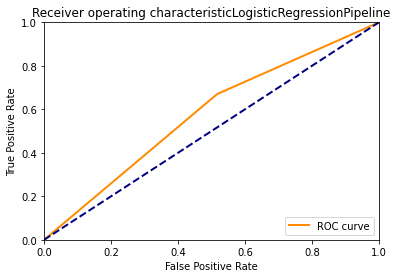

LogisticRegressionPipeline Test Accuracy: 0.5763741570514479
LogisticRegressionPipeline F1 score: 0.6120764878449396
LogisticRegressionPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.48      0.53    232539
           1       0.56      0.67      0.61    231309

    accuracy                           0.58    463848
   macro avg       0.58      0.58      0.57    463848
weighted avg       0.58      0.58      0.57    463848



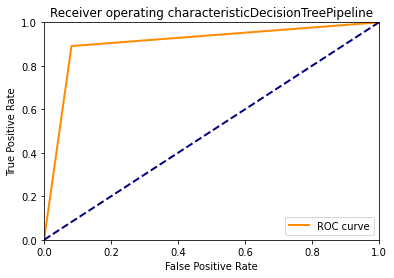

DecisionTreePipeline Test Accuracy: 0.9046433314361602
DecisionTreePipeline F1 score: 0.9030976078378965
DecisionTreePipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.92      0.91    232539
           1       0.92      0.89      0.90    231309

    accuracy                           0.90    463848
   macro avg       0.90      0.90      0.90    463848
weighted avg       0.90      0.90      0.90    463848



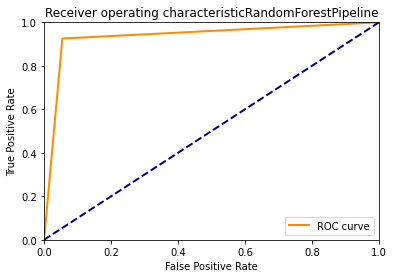

RandomForestPipeline Test Accuracy: 0.9355521636398131
RandomForestPipeline F1 score: 0.9347457849103721
RandomForestPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94    232539
           1       0.94      0.93      0.93    231309

    accuracy                           0.94    463848
   macro avg       0.94      0.94      0.94    463848
weighted avg       0.94      0.94      0.94    463848



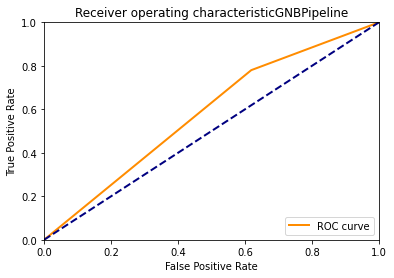

GNBPipeline Test Accuracy: 0.5801749711112261
GNBPipeline F1 score: 0.6495548689081285
GNBPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.38      0.48    232539
           1       0.56      0.78      0.65    231309

    accuracy                           0.58    463848
   macro avg       0.60      0.58      0.56    463848
weighted avg       0.60      0.58      0.56    463848



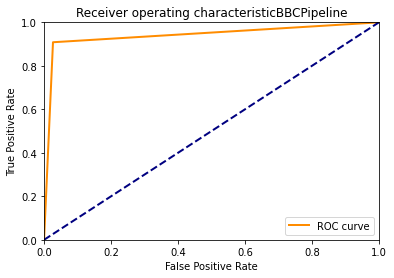

BBCPipeline Test Accuracy: 0.9410474983184146
BBCPipeline F1 score: 0.9389163772017022
BBCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94    232539
           1       0.97      0.91      0.94    231309

    accuracy                           0.94    463848
   macro avg       0.94      0.94      0.94    463848
weighted avg       0.94      0.94      0.94    463848



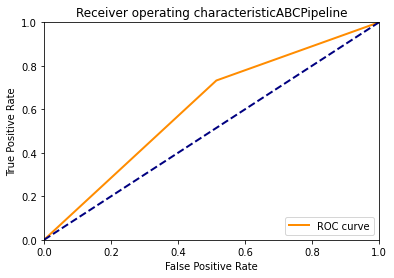

ABCPipeline Test Accuracy: 0.6087015574067367
ABCPipeline F1 score: 0.6512475140987827
ABCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.49      0.55    232539
           1       0.59      0.73      0.65    231309

    accuracy                           0.61    463848
   macro avg       0.62      0.61      0.60    463848
weighted avg       0.62      0.61      0.60    463848



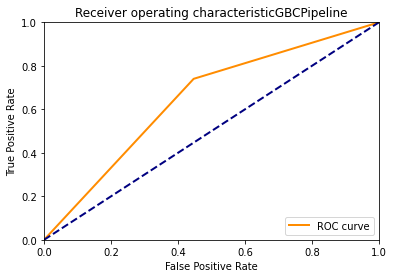

GBCPipeline Test Accuracy: 0.6465242924406271
GBCPipeline F1 score: 0.6762499580401905
GBCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.55      0.61    232539
           1       0.62      0.74      0.68    231309

    accuracy                           0.65    463848
   macro avg       0.65      0.65      0.64    463848
weighted avg       0.65      0.65      0.64    463848



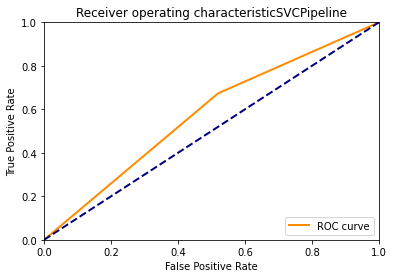

SVCPipeline Test Accuracy: 0.5766307066107863
SVCPipeline F1 score: 0.6133822629006125
SVCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.48      0.53    232539
           1       0.56      0.67      0.61    231309

    accuracy                           0.58    463848
   macro avg       0.58      0.58      0.57    463848
weighted avg       0.58      0.58      0.57    463848



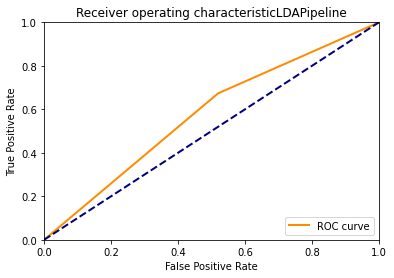

LDAPipeline Test Accuracy: 0.5766328624894362
LDAPipeline F1 score: 0.6133789035583362
LDAPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.48      0.53    232539
           1       0.56      0.67      0.61    231309

    accuracy                           0.58    463848
   macro avg       0.58      0.58      0.57    463848
weighted avg       0.58      0.58      0.57    463848



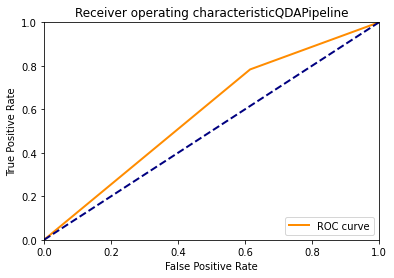

QDAPipeline Test Accuracy: 0.5835575447129232
QDAPipeline F1 score: 0.6523490367725402
QDAPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.38      0.48    232539
           1       0.56      0.78      0.65    231309

    accuracy                           0.58    463848
   macro avg       0.60      0.58      0.57    463848
weighted avg       0.60      0.58      0.57    463848



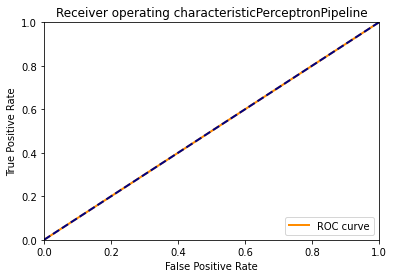

PerceptronPipeline Test Accuracy: 0.50132586536969
PerceptronPipeline F1 score: 0.0
PerceptronPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67    232539
           1       0.00      0.00      0.00    231309

    accuracy                           0.50    463848
   macro avg       0.25      0.50      0.33    463848
weighted avg       0.25      0.50      0.33    463848



In [74]:
#Defining variables for choosing best model

accuracy=0.0
classifier=0
pipeline=""

# Creating dictionary of pipelines and training models
PipelineDict = {0 :'LogisticRegressionPipeline',1: 'DecisionTreePipeline',2: 'RandomForestPipeline',3:'GNBPipeline', 4:'BBCPipeline', 5:'ABCPipeline', 6:'GBCPipeline', 7:'SVCPipeline', 8:'LDAPipeline', 9:'QDAPipeline', 10:'PerceptronPipeline'}

# Fit the pipelines
for mypipe in mypipeline:
    mypipe.fit(X_train, y_train)

    for i,model in enumerate(mypipeline):
    model_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, model_pred)

          
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(PipelineDict[i]))
    plt.legend(loc="lower right")
    plt.show()
    print("{} Test Accuracy: {}".format(PipelineDict[i],model.score(X_test,y_test)))
    print('{} F1 score: {}'.format(PipelineDict[i],f1_score(y_test,model_pred)))
    print("{} Classification Report: \n {}".format(PipelineDict[i],classification_report(y_test,model_pred)))
    


In [76]:
runs = 30
params = {'eta': 0.1, 'max_depth': 15, 'scale_pos_weight': 10, 'objective': 'reg:linear','subsample':0.25,'verbose': False}
xgb_model = None

for i in range(runs):
   
    print("count: ", i+1)

    if True:

        temp, X_cv, label, Y_cv = train_test_split(feature_df,target_df, test_size=0.2)
        xg_train_1 = clf1.DMatrix(temp, label=label)
        xg_test = clf1.DMatrix(X_cv, label=Y_cv)
        model = clf1.train(params, xg_train_1, 50, xgb_model=xgb_model)
        model.save_model('model.model')
        xgb_model = 'model.model'
        
        print(classification_report(Y_cv, (model.predict(xg_test)>0.5).astype(int)))
        print('F1 score:', f1_score(Y_cv, (model.predict(xg_test)>0.5).astype(int)))
    

count:  1
[14:00:09] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:09] WARNING: ../src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    154566
           1       0.87      0.66      0.75      3477

    accuracy                           0.99    158043
   macro avg       0.93      0.83      0.87    158043
weighted avg       0.99      0.99      0.99    158043

F1 score: 0.7497949138638229
count:  2
[14:00:59] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:00:59] WARNING: ../src/learner.cc:573: 
Parameters: {

## Machine Learning Algorithm Explainability 
Machine Learning Algorithm Explainability through the feature importance existing in which it showcase which feature is more important in classification of the dataset.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

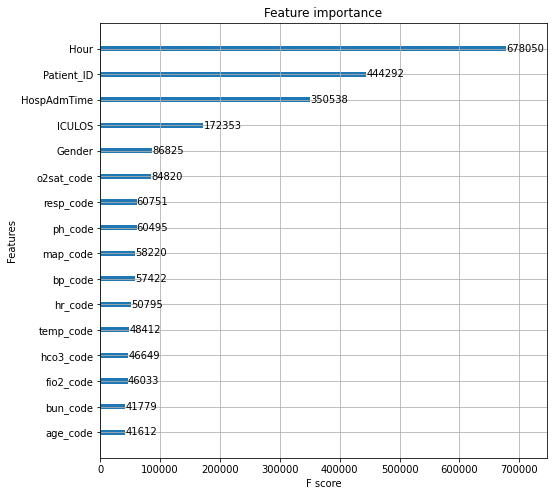

In [77]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
clf1.plot_importance(model, ax=ax)

### Grid Search CV on the best performed Algorithm to fine tune with better hyperparameters

In [95]:
clf = GridSearchCV(make_pipeline(StandardScaler(), LogisticRegression()),
                    param_grid={'logisticregression__C': [1000,100, 10, 1.0, 0.1, 0.01],
                                'logisticregression__penalty': ['l1', 'l2']},
                    cv=5,
                    refit=True)

clf.fit(X_train, y_train)
print(clf.best_params_)
best_params = clf.best_params_
y_pred = clf.predict(X_test)
clf.estimator.set_params(**best_params)
clf.estimator.fit(X_train, y_train)
model_pred = clf.predict(X_test)
print(classification_report(y_test,model_pred), '\n',f1_score(y_test,model_pred))

{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.68      0.74      0.71    232539
           1       0.71      0.65      0.68    231309

    accuracy                           0.69    463848
   macro avg       0.69      0.69      0.69    463848
weighted avg       0.69      0.69      0.69    463848
 
 0.6764104526445208


In [106]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('classifier', DecisionTreeClassifier())
])

# Set up the grid search
param_grid = {
    'pca__n_components': [2, 3, 4],
    'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(c)
print(grid_search.best_params_)
best_params = grid_search.best_params_
# Predict on the test set
y_pred = grid_search.predict(X_test)
grid_search.estimator.set_params(**best_params)
grid_search.estimator.fit(X_train, y_train)
model_pred = clf.predict(X_test)
print(classification_report(y_test,model_pred), '\n',f1_score(y_test,model_pred))

{'classifier__max_depth': 7, 'pca__n_components': 4}
              precision    recall  f1-score   support

           0       0.68      0.74      0.71    232539
           1       0.71      0.65      0.68    231309

    accuracy                           0.69    463848
   macro avg       0.69      0.69      0.69    463848
weighted avg       0.69      0.69      0.69    463848
 
 0.6764104526445208


In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

# Set up the grid search
param_grid_1 = {
    'pca__n_components': [2, 3, 4],
    'classifier__n_estimators': [10, 20, 30],
    'classifier__max_depth': [3, 5, 7]
}

grid_search_1 = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search to the data
grid_search_1.fit(X_train, y_train)
print(grid_search_1.best_params_)
best_params = grid_search_1.best_params_
# Predict on the test set
# y_pred = grid_search_1.predict(X_test)
grid_search_1.estimator.set_params(**best_params)
grid_search_1.estimator.fit(X_train, y_train)
model_pred = grid_search_1.predict(X_test)
print(classification_report(y_test,model_pred), '\n',f1_score(y_test,model_pred))

# Validation Set testing on the train dataset which gave good accuracy

In [108]:
df_v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761995 entries, 0 to 761994
Data columns (total 36 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Hour         761995 non-null  int64  
 1   HR           761862 non-null  float64
 2   O2Sat        761832 non-null  float64
 3   Temp         761311 non-null  float64
 4   SBP          760990 non-null  float64
 5   MAP          759321 non-null  float64
 6   DBP          760890 non-null  float64
 7   Resp         760697 non-null  float64
 8   BaseExcess   30121 non-null   float64
 9   HCO3         22331 non-null   float64
 10  FiO2         268430 non-null  float64
 11  pH           262548 non-null  float64
 12  PaCO2        263803 non-null  float64
 13  BUN          719213 non-null  float64
 14  Chloride     75327 non-null   float64
 15  Glucose      727382 non-null  float64
 16  Potassium    722365 non-null  float64
 17  Hct          709377 non-null  float64
 18  Hgb          709632 non-

In [112]:
df_v.drop([ 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp','BaseExcess', 'HCO3', 'FiO2','pH', 'PaCO2', 'BUN', 'Chloride','Glucose', 'Potassium', 'Hct', 'Hgb', 'Age'], axis=1)

KeyError: "['HR' 'O2Sat' 'Temp' 'SBP' 'MAP' 'DBP' 'Resp' 'BaseExcess' 'HCO3' 'FiO2'\n 'pH' 'PaCO2' 'BUN' 'Chloride' 'Glucose' 'Potassium' 'Hct' 'Hgb' 'Age'] not found in axis"

In [114]:
df_v.columns

Index(['Hour', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'age_code', 'hr_code', 'o2sat_code', 'temp_code', 'bp_code',
       'resp_code', 'map_code', 'fio2_code', 'ph_code', 'hco3_code',
       'bun_code'],
      dtype='object')

In [115]:
df_v.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 761995 entries, 0 to 761994
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Hour         761995 non-null  int64  
 1   Gender       761995 non-null  int64  
 2   HospAdmTime  761995 non-null  float64
 3   ICULOS       761995 non-null  int64  
 4   SepsisLabel  761995 non-null  int64  
 5   Patient_ID   761995 non-null  int64  
 6   age_code     761995 non-null  float64
 7   hr_code      761995 non-null  float64
 8   o2sat_code   761995 non-null  float64
 9   temp_code    761995 non-null  float64
 10  bp_code      761995 non-null  float64
 11  resp_code    761995 non-null  float64
 12  map_code     761995 non-null  float64
 13  fio2_code    761995 non-null  float64
 14  ph_code      761995 non-null  float64
 15  hco3_code    761995 non-null  float64
 16  bun_code     761995 non-null  float64
dtypes: float64(12), int64(5)
memory usage: 104.6 MB


In [116]:
X_Val = df_v.drop(['SepsisLabel'],axis=1)
y_Val = df_v['SepsisLabel']

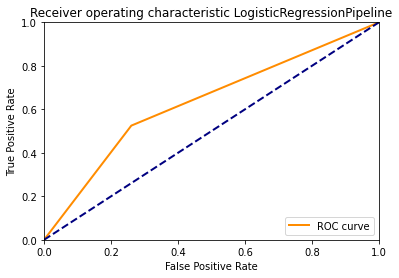

LogisticRegressionPipeline Test Accuracy: 0.7363657241845419
LogisticRegressionPipeline F1 score: 0.05335281089486829
LogisticRegressionPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.74      0.85    751215
           1       0.03      0.53      0.05     10780

    accuracy                           0.74    761995
   macro avg       0.51      0.63      0.45    761995
weighted avg       0.98      0.74      0.84    761995



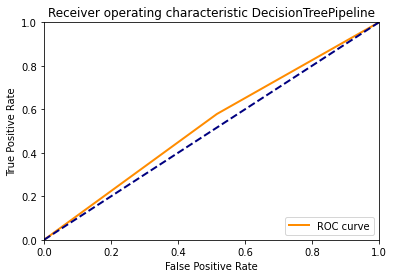

DecisionTreePipeline Test Accuracy: 0.4852052834992356
DecisionTreePipeline F1 score: 0.030819404810436202
DecisionTreePipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.48      0.65    751215
           1       0.02      0.58      0.03     10780

    accuracy                           0.49    761995
   macro avg       0.50      0.53      0.34    761995
weighted avg       0.97      0.49      0.64    761995



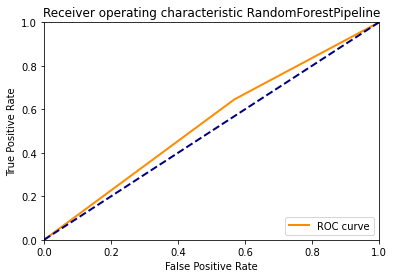

RandomForestPipeline Test Accuracy: 0.43459865222212746
RandomForestPipeline F1 score: 0.031298271175236585
RandomForestPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.43      0.60    751215
           1       0.02      0.65      0.03     10780

    accuracy                           0.43    761995
   macro avg       0.50      0.54      0.32    761995
weighted avg       0.97      0.43      0.59    761995



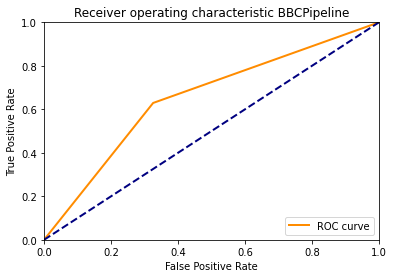

BBCPipeline Test Accuracy: 0.6736199056424255
BBCPipeline F1 score: 0.051733341467506515
BBCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.67      0.80    751215
           1       0.03      0.63      0.05     10780

    accuracy                           0.67    761995
   macro avg       0.51      0.65      0.43    761995
weighted avg       0.98      0.67      0.79    761995



In [ ]:
accuracy=0.0
classifier=0
pipeline=""
from sklearn.metrics import confusion_matrix
# Creating dictionary of pipelines and training models
# Pipline Dictionary for the all ML Algos as well as the best suited.
# PipelineDict = {0 :'LogisticRegressionPipeline',1: 'DecisionTreePipeline',2: 'RandomForestPipeline',3:'GNBPipeline', 4:'BBCPipeline', 5:'ABCPipeline', 6:'GBCPipeline', 7:'SVCPipeline', 8:'LDAPipeline', 9:'QDAPipeline', 10:'PerceptronPipeline'}
PipelineDict = {0 :'LogisticRegressionPipeline',1: 'DecisionTreePipeline',2: 'RandomForestPipeline',3:'BBCPipeline'}

#getting test accuracy for all classifiers
for i,model in enumerate(mypipeline):
    model_preds = model.predict(X_Val)
    fpr, tpr, _ = roc_curve(y_Val, model_preds)

          
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(PipelineDict[i]))
    plt.legend(loc="lower right")
    plt.show()
    print("{} Test Accuracy: {}".format(PipelineDict[i],model.score(X_Val,y_Val)))
    print('{} F1 score: {}'.format(PipelineDict[i],f1_score(y_Val,model_preds)))
    print("{} Classification Report: \n {}".format(PipelineDict[i],classification_report(y_Val,model_preds)))
    perm = PermutationImportance(my_model).fit(X_test, y_test)
    eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Applying all the algorithms individually as well as applying eli5 for the ML explainability that which feature playing important role in the which algorithm along with weight of each feature assigned in the Algorithm.

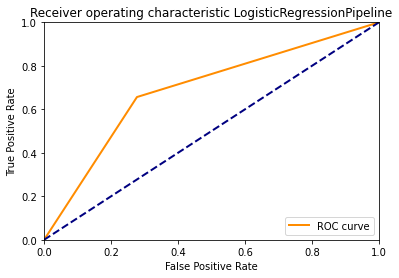

LogisticRegressionPipeline Test Accuracy: 0.6896418654386782
LogisticRegressionPipeline F1 score: 0.6784425934736527
LogisticRegressionPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.72      0.70    232539
           1       0.70      0.66      0.68    231309

    accuracy                           0.69    463848
   macro avg       0.69      0.69      0.69    463848
weighted avg       0.69      0.69      0.69    463848



In [133]:
LogisticRegressionPipeline=Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',LDA(n_components=1)),
                     ('logistic_classifier',LogisticRegression(C= 1000, penalty='l2'))])

my_model = LogisticRegressionPipeline.fit(X_train, y_train)
model_pred = LogisticRegressionPipeline.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, model_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic LogisticRegressionPipeline')
plt.legend(loc="lower right")
plt.show()
print("LogisticRegressionPipeline Test Accuracy: {}".format(LogisticRegressionPipeline.score(X_test,y_test)))
print('LogisticRegressionPipeline F1 score: {}'.format(f1_score(y_test,model_pred)))
print("LogisticRegressionPipeline Classification Report: \n {}".format(classification_report(y_test,model_pred)))
perm = PermutationImportance(my_model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

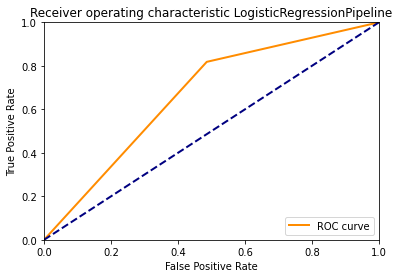

LogisticRegressionPipeline Test Accuracy: 0.5184207245454366
LogisticRegressionPipeline F1 score: 0.04587563864224334
LogisticRegressionPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.51      0.68    751215
           1       0.02      0.82      0.05     10780

    accuracy                           0.52    761995
   macro avg       0.51      0.67      0.36    761995
weighted avg       0.98      0.52      0.67    761995



In [135]:
model_preds = LogisticRegressionPipeline.predict(X_Val)
fpr, tpr, _ = roc_curve(y_Val, model_preds)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic LogisticRegressionPipeline')
plt.legend(loc="lower right")
plt.show()
print("LogisticRegressionPipeline Test Accuracy: {}".format(LogisticRegressionPipeline.score(X_Val,y_Val)))
print('LogisticRegressionPipeline F1 score: {}'.format(f1_score(y_Val,model_preds)))
print("LogisticRegressionPipeline Classification Report: \n {}".format(classification_report(y_Val,model_preds)))

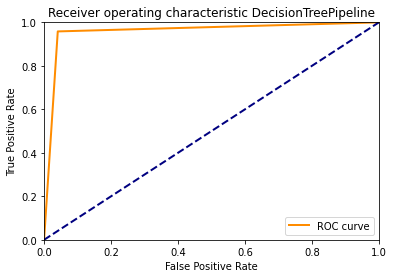

DecisionTreePipeline Test Accuracy: 0.9587278591262655
DecisionTreePipeline F1 score: 0.958607030577694
DecisionTreePipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96    232539
           1       0.96      0.96      0.96    231309

    accuracy                           0.96    463848
   macro avg       0.96      0.96      0.96    463848
weighted avg       0.96      0.96      0.96    463848



In [146]:
DecisionTreePipeline=Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=5)),
                     ('decisiontree_classifier',DecisionTreeClassifier())])


my_model = DecisionTreePipeline.fit(X_train, y_train)
model_pred = DecisionTreePipeline.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, model_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic DecisionTreePipeline')
plt.legend(loc="lower right")
plt.show()
print("DecisionTreePipeline Test Accuracy: {}".format(DecisionTreePipeline.score(X_test,y_test)))
print('DecisionTreePipeline F1 score: {}'.format(f1_score(y_test,model_pred)))
print("DecisionTreePipeline Classification Report: \n {}".format(classification_report(y_test,model_pred)))
perm = PermutationImportance(my_model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

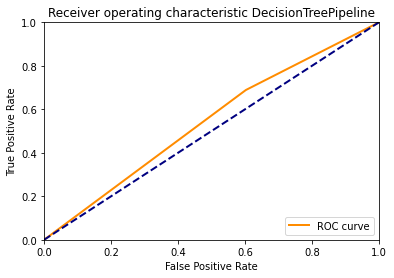

DecisionTreePipeline Test Accuracy: 0.4013044705017749
DecisionTreePipeline F1 score: 0.03153333885283522
DecisionTreePipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.40      0.57    751215
           1       0.02      0.69      0.03     10780

    accuracy                           0.40    761995
   macro avg       0.50      0.54      0.30    761995
weighted avg       0.98      0.40      0.56    761995



In [147]:
model_preds = DecisionTreePipeline.predict(X_Val)
fpr, tpr, _ = roc_curve(y_Val, model_preds)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic DecisionTreePipeline')
plt.legend(loc="lower right")
plt.show()
print("DecisionTreePipeline Test Accuracy: {}".format(DecisionTreePipeline.score(X_Val,y_Val)))
print('DecisionTreePipeline F1 score: {}'.format(f1_score(y_Val,model_preds)))
print("DecisionTreePipeline Classification Report: \n {}".format(classification_report(y_Val,model_preds)))

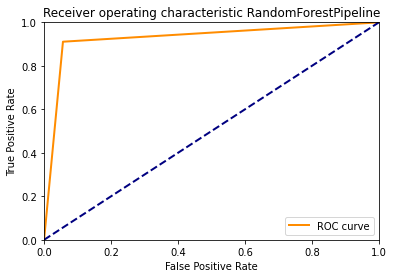

RandomForestPipeline Test Accuracy: 0.9273619806488332
RandomForestPipeline F1 score: 0.9259743426935557
RandomForestPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93    232539
           1       0.94      0.91      0.93    231309

    accuracy                           0.93    463848
   macro avg       0.93      0.93      0.93    463848
weighted avg       0.93      0.93      0.93    463848



In [151]:
RandomForestPipeline=Pipeline([('myscaler',MinMaxScaler()),
                     ('mypca',PCA(n_components=3)),
                     ('randomforest_classifier',RandomForestClassifier())])


my_model = RandomForestPipeline.fit(X_train, y_train)
model_pred = RandomForestPipeline.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, model_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic RandomForestPipeline')
plt.legend(loc="lower right")
plt.show()
print("RandomForestPipeline Test Accuracy: {}".format(RandomForestPipeline.score(X_test,y_test)))
print('RandomForestPipeline F1 score: {}'.format(f1_score(y_test,model_pred)))
print("RandomForestPipeline Classification Report: \n {}".format(classification_report(y_test,model_pred)))
perm = PermutationImportance(my_model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

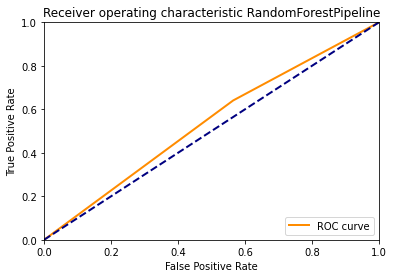

RandomForestPipeline Test Accuracy: 0.43802912092599033
RandomForestPipeline F1 score: 0.03125982666609357
RandomForestPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.44      0.60    751215
           1       0.02      0.64      0.03     10780

    accuracy                           0.44    761995
   macro avg       0.50      0.54      0.32    761995
weighted avg       0.97      0.44      0.60    761995



In [149]:
model_preds = RandomForestPipeline.predict(X_Val)
fpr, tpr, _ = roc_curve(y_Val, model_preds)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic RandomForestPipeline')
plt.legend(loc="lower right")
plt.show()
print("RandomForestPipeline Test Accuracy: {}".format(RandomForestPipeline.score(X_Val,y_Val)))
print('RandomForestPipeline F1 score: {}'.format(f1_score(y_Val,model_preds)))
print("RandomForestPipeline Classification Report: \n {}".format(classification_report(y_Val,model_preds)))

[17:25:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:27:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

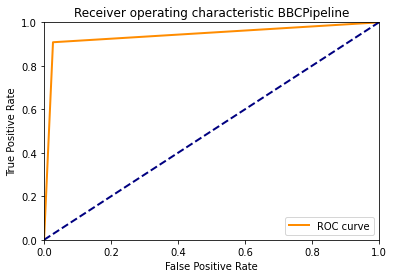

BBCPipeline Test Accuracy: 0.9410474983184146
BBCPipeline F1 score: 0.9389163772017022
BBCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94    232539
           1       0.97      0.91      0.94    231309

    accuracy                           0.94    463848
   macro avg       0.94      0.94      0.94    463848
weighted avg       0.94      0.94      0.94    463848



NameError: name 'PermutationImportance' is not defined

In [152]:
BBCPipeline = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

my_model = BBCPipeline.fit(X_train, y_train)
model_pred = BBCPipeline.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, model_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic BBCPipeline')
plt.legend(loc="lower right")
plt.show()
print("BBCPipeline Test Accuracy: {}".format(BBCPipeline.score(X_test,y_test)))
print('BBCPipeline F1 score: {}'.format(f1_score(y_test,model_pred)))
print("BBCPipeline Classification Report: \n {}".format(classification_report(y_test,model_pred)))
perm = PermutationImportance(my_model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

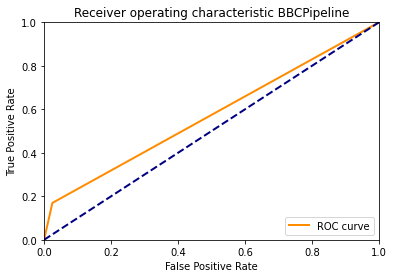

BBCPipeline Test Accuracy: 0.9637911009914764
BBCPipeline F1 score: 0.11705974591186918
BBCPipeline Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98    751215
           1       0.09      0.17      0.12     10780

    accuracy                           0.96    761995
   macro avg       0.54      0.57      0.55    761995
weighted avg       0.98      0.96      0.97    761995



Weight,Feature
0.0885 ± 0.0006,o2sat_code
0.0840 ± 0.0005,map_code
0.0702 ± 0.0008,resp_code
0.0651 ± 0.0005,ICULOS
0.0391 ± 0.0005,bp_code
0.0373 ± 0.0004,Patient_ID
0.0366 ± 0.0004,hr_code
0.0341 ± 0.0001,temp_code
0.0304 ± 0.0003,HospAdmTime
0.0216 ± 0.0004,Hour


In [154]:
model_preds = BBCPipeline.predict(X_Val)
fpr, tpr, _ = roc_curve(y_Val, model_preds)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic BBCPipeline')
plt.legend(loc="lower right")
plt.show()
print("BBCPipeline Test Accuracy: {}".format(BBCPipeline.score(X_Val,y_Val)))
print('BBCPipeline F1 score: {}'.format(f1_score(y_Val,model_preds)))
print("BBCPipeline Classification Report: \n {}".format(classification_report(y_Val,model_preds)))
perm = PermutationImportance(my_model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())